In [1]:
project_root_dir = "../../../"

import os
work_dir = os.path.abspath(project_root_dir)

import sys
sys.path.append(project_root_dir)

import wandb
import re

import pandas as pd
from IPython.display import display, HTML
from functools import reduce
from itertools import cycle

import numpy as np

from src.utils import evaluation_helpers
from src.datamodules import IEGenericOutputDataset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_palette("deep")

In [2]:
run_name2wandb_path = {
 'inf_sc_fully_synthetic_gcp_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_small_ordered_constraint-R-max-T5_lp-0.6': 'epfl-dlab/SynthIE/1jyinpln',
 'inf_sc_fully_synthetic_gcp_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_small_ordered_constraint-R-max-T5_lp-0.6': 'epfl-dlab/SynthIE/1aydm1hh',
 'inf_sc_fully_synthetic_gcp_datamodule-rebel_world-genie_t5_tokenizeable_split-test_small_constraint-R-max-T5_lp-0.6': 'epfl-dlab/SynthIE/3tpuu28l',
}


# Useful for the process_results launcher
# print(" ".join(list(run_name2wandb_path.values())))

In [3]:
# ~~~ Which experiments and results consider? ~~~
# model_id_wandb_run_path_pairs = [("R", "martinj96/SynthIE/izr0vgpw"), ("R+S", "martinj96/SynthIE/2f857wrl"), ("R", "martinj96/SynthIE/3274th6j"), ("R+S", "martinj96/SynthIE/runs/22djwbxk")]
model_id_wandb_run_path_pairs = [("sc_fs_ms", wandb_path) if "_ms_" in run_name else ("sc_fs_gcp", wandb_path) for run_name, wandb_path in run_name2wandb_path.items()][::-1]

dataset_id_kwargs = {"name": "rebel",
                     "split": "train",
                     "filter_on_num_tokens": True,
                     "linearization_id":  "subject_collapsed",
                     "constrained_world": "genie_t5_tokenizeable"}
dataset_id = evaluation_helpers.get_dataset_id(from_cfg=False, **dataset_id_kwargs)
print(f"Dataset ID: {dataset_id}")

metrics = ["rel_centric_triplet_set_f1", "rel_centric_triplet_set_precision", "rel_centric_triplet_set_recall"]

n_bootstrap_samples = 50  # Set to None to present only the corpus level metric (without confidence intervals)
confidence_level = 0.95
confidence_interval_type = "percentile"
assert confidence_interval_type in ["percentile", "std"]

dataset_name2dataset_label = {"rebel": "REBEL", "sdg_code_davinci_002": "[SDG] Code Davinci", "sdg_text_davinci_003": "[SGD] Text Davinci"}
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ~~~ Plotting parameters ~~~
x_axis_label = "Number of relation occurrences in REBEL's training dataset"
metric_name2label = {"rel_centric_triplet_set_precision": "P", "rel_centric_triplet_set_recall": "R", "rel_centric_triplet_set_f1": "F1"}
right_y_axis_label = "Number of relations"

figsize=(14, 8)
linestyle="--"
line_colors=["r", "GoldenRod", "violet", "yellow"]
capsize=3
marker_style="o"
marker_size=50
marker_linewidth=2.5
drop_top_frame=True
legend_pos=(0.5, 1.03)
show_plot=True

output_dir="plots"
output_file_name=None
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Dataset ID: name-rebel_split-train_filtering-True_linearization-subject_collapsed_constrained_world-genie_t5_tokenizeable


##### Define Experiment ID

In [4]:
# ~~~ Optional ~~~~
def retrieve_constraint_module_id(hydra_config):
    cm_cfg = hydra_config['model']['constraint_module']

    if cm_cfg == None or cm_cfg == 'None':
        return "free"

    identifier2label = {'genie': 'R-max'}
    return identifier2label.get(cm_cfg['identifier'], cm_cfg['identifier'])

def retrieve_lenght_penalty(hydra_config):
    return hydra_config['model']['hparams_overrides']['inference']['hf_generation_params']['length_penalty']
# ~~~~~~~~~~~~~~~~~~

# The names of these functions should not change    
def get_exp_id(model_id, hydra_config):
    return f"{model_id} -- ({retrieve_constraint_module_id(hydra_config)}) lp_{retrieve_lenght_penalty(hydra_config)} [{dataset_name2dataset_label[retrieve_dataset_name(hydra_config)]}]"

def retrieve_dataset_name(hydra_config):
    return hydra_config['datamodule']['name']

results_df_field2getter = {"LP": retrieve_lenght_penalty, "Constraint": retrieve_constraint_module_id}

## Main Part

In [5]:
wandb_configs = {}
hydra_configs = {}
abs_exp_dirs = {}

output_datasets = {}
results = {}

exp_id2wandb_run_path = {}
exp_id2model_id = {}

for model_id, wandb_run_path in model_id_wandb_run_path_pairs:
    api = wandb.Api()
    run = api.run(wandb_run_path)
    wandb_config, hydra_config, abs_exp_dir = evaluation_helpers.prepare_data_for_experiment(wandb_run_path, work_dir, print)
    exp_id = get_exp_id(model_id, hydra_config)
    exp_id2wandb_run_path[exp_id] = wandb_run_path
    exp_id2model_id[exp_id] = model_id

    wandb_configs[exp_id], hydra_configs[exp_id], abs_exp_dirs[exp_id] = wandb_config, hydra_config, abs_exp_dir

    linearization_class_id = hydra_configs[exp_id]['datamodule'].get("linearization_class_id")
    data_dir = os.path.join(abs_exp_dirs[exp_id], "predictions")
    output_datasets[exp_id] = IEGenericOutputDataset(data_dir=data_dir, seed=123, linearization_class_id=linearization_class_id)

    # Load existing results data
    results[exp_id] = evaluation_helpers.Results(abs_exp_dirs[exp_id])

exp_ids = list(results.keys())

Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_sc_fully_synthetic_gcp_datamodule-rebel_world-genie_t5_tokenizeable_split-test_small_constraint-R-max-T5_lp-0.6/2023-01-27_17-07-01
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_sc_fully_synthetic_gcp_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_small_ordered_constraint-R-max-T5_lp-0.6/2023-01-27_16-11-59
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_sc_fully_synthetic_gcp_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_small_ordered_constraint-R-max-T5_lp-0.6/2023-01-27_16-39-34
Loading the existing results


In [6]:
def get_bucket_plot_data(results_obj, metric_name, dataset_id, left_y_label):
    # ~~~ Get the data ~~~
    if n_bootstrap_samples is None:
        scores_dict = results_obj.get_score(metric_name, dataset_id=dataset_id, per_bucket=True)
    else:
        if confidence_interval_type == "percentile":
            scores_dict = results_obj.get_percentile_based_ci(metric_name, 
                                                               confidence_level=confidence_level,
                                                               n_bootstrap_samples=n_bootstrap_samples,
                                                               dataset_id=dataset_id,
                                                               per_bucket=True)
        elif confidence_interval_type == "std":
            scores_dict = results_obj.get_std_based_ci(metric_name, 
                                                        n_bootstrap_samples=n_bootstrap_samples, 
                                                        dataset_id=dataset_id,
                                                        per_bucket=True)
        else:
            raise ValueError(f"Unknown confidence interval type: {confidence_interval_type}")
    scores_dict = {int(k): v for k, v in scores_dict.items()}

    metadata = results_obj.get_metadata(metric_id=metric_name, dataset_id=dataset_id)

    # ~~~~ Concerning the X axis ~~~~
    bucket_indices = sorted(list(scores_dict.keys()))
    bucket_idx2label = metadata["bucket_idx2label"]
    bucket_idx2label = {int(k): v for k, v in bucket_idx2label.items()}
    bucket_labels = [bucket_idx2label[bucket_idx] for bucket_idx in bucket_indices]

    # ~~~~ Concerning the Y axis ~~~~

    # Scores
    if n_bootstrap_samples is None:
        scores = [scores_dict[bucket_index] for bucket_index in bucket_indices]
        scores_err = None
    else:
        scores = []
        scores_err = []
        for bucket_index in bucket_indices:
            lower, mean, upper = scores_dict[bucket_index]
            scores.append(mean)
            scores_err.append((mean-lower, upper-mean)) 
        scores_err = np.array(scores_err).T

    # Distribution of relations
    bucket_idx2num_rels = metadata['bucket_idx2num_rels']
    bucket_idx2num_rels = {int(k): v for k, v in bucket_idx2num_rels.items()}
    freqs = [bucket_idx2num_rels[bucket_index] for bucket_index in bucket_indices]

    data_obj = {
        "x": bucket_labels,
        "left_y": scores,
        "left_y_err": scores_err,
        "left_y_label": left_y_label,
        "right_y": freqs,
    }

    return data_obj


def get_bucket_plot_bar_version(
        x,
        x_axis_label,

        left_ys,
        left_y_errs,
        left_y_labels,
        left_y_axis_label,
        left_y_lim,

        right_y,
        right_y_label,
        right_y_axis_label,
        right_y_lim,
        right_y_hatch=None,
        right_y_alpha=1,

        figsize=figsize,
        linestyle=linestyle,
        line_colors=line_colors,
        capsize=capsize,
        marker_style=marker_style,
        marker_size=marker_size,
        marker_linewidth=marker_linewidth,
        drop_top_frame=drop_top_frame,
        legend_pos=legend_pos,
        show_plot=show_plot,

        output_dir=output_dir,
        output_file_name=output_file_name
):

    c = cycle(line_colors)

    fig, ax = plt.subplots(figsize=figsize)

    if x_axis_label:
        ax.set_xlabel(x_axis_label)

    # ~~~ Left Plot ~~~
    plt.setp(ax.patches, linewidth=0)

    for left_y, left_y_label, left_y_err in zip(left_ys, left_y_labels, left_y_errs):
        color = next(c)
        sns.lineplot(x=x, y=left_y, ax=ax, color=color, label=left_y_label, linestyle=linestyle)

        if left_y_err is not None:
            ax.errorbar(x=x, y=left_y, yerr=left_y_err, fmt="none", color="black", capsize=capsize, zorder=10000)

        if marker_size != 0:
            sns.scatterplot(
                ax=ax,
                x=x,
                y=left_y,
                marker=marker_style,
                color=color,
                linewidth=marker_linewidth,
                s=marker_size,
                edgecolor="none",
            )

    if left_y_axis_label:
        ax.set_ylabel(left_y_axis_label)

    if left_y_lim:
        ax.set_ylim(*left_y_lim)

    # ~~~ Right Plot ~~~
    ax2 = ax.twinx()
    plt.setp(ax2.patches, linewidth=0)

    sns.barplot(
        ax=ax2,
        x=x,
        y=right_y,
        palette=["#004d99"] * len(x),
        label=right_y_label,
        hatch=right_y_hatch,
        edgecolor="black",
        zorder=0,
        alpha=right_y_alpha,
    )

    if right_y_axis_label:
        ax2.set_ylabel(right_y_axis_label)

    if right_y_lim:
        ax2.set_ylim(*right_y_lim)

    ax.set_zorder(ax2.get_zorder() + 1)
    ax.set_frame_on(False)

    # ~~~~ General ~~~~
    if drop_top_frame:
        ax.spines["top"].set_visible(False)
        ax2.spines["top"].set_visible(False)

    ax.legend(loc="upper right", bbox_to_anchor=(1, 1.03), bbox_transform=ax.transAxes, frameon=False)
    ax2.legend(loc="upper right", bbox_to_anchor=legend_pos, bbox_transform=ax2.transAxes, frameon=False)
    plt.tight_layout(rect=(0, 0, 1, 0.98))

    if show_plot:
        plt.show()

    if output_file_name is not None:
        path_to_pdf_output_file = os.path.join(output_dir, output_file_name) + ".pdf"
        plt.savefig(path_to_pdf_output_file, dpi=300)

        path_to_png_output_file = os.path.join(output_dir, output_file_name) + ".png"
        plt.savefig(path_to_png_output_file, dpi=300)

    return fig, ax, ax2

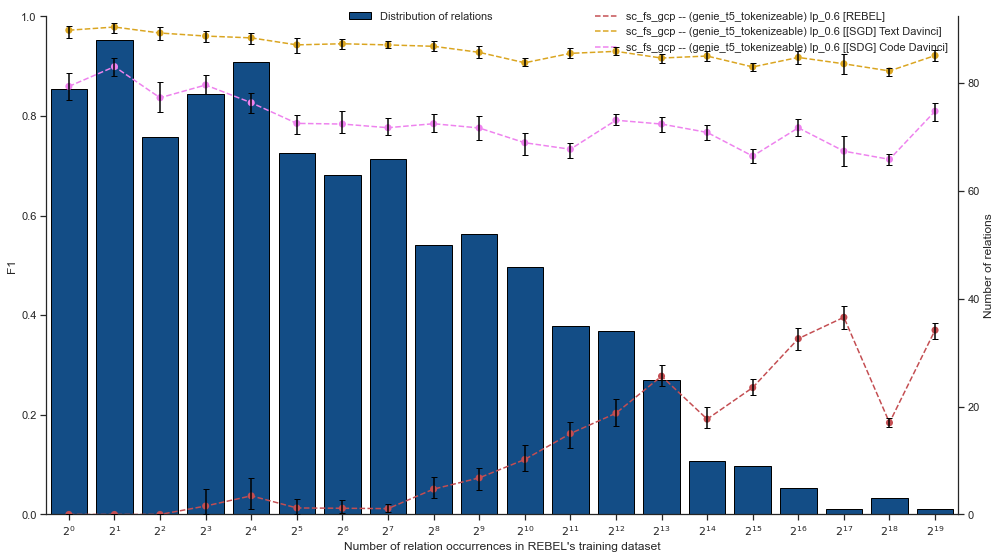

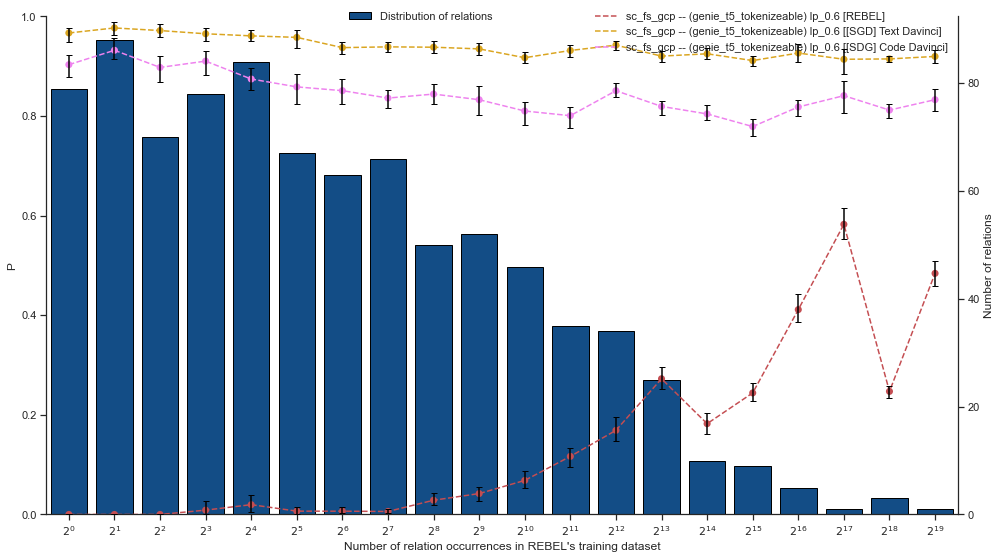

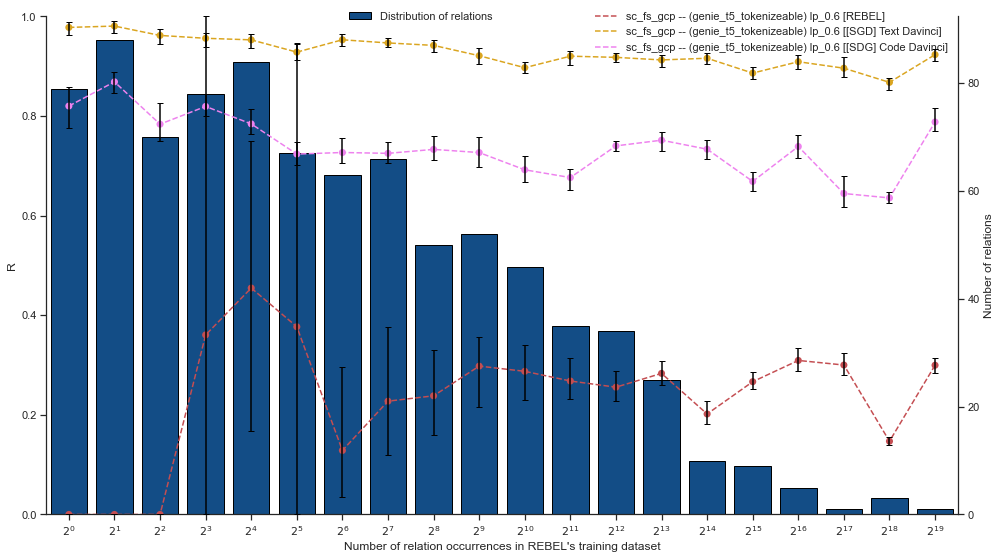

In [8]:
def get_plot_for_metric(metric_name):
    data_objs = []

    for exp_id in exp_id2wandb_run_path.keys():
        curr_results = results[exp_id]
        data_objs.append(get_bucket_plot_data(curr_results, metric_name, dataset_id, exp_id))

    plot_data = {
        "x": data_objs[0]["x"],  # ToDo: verify that all data_objs have the same x
        "x_axis_label": x_axis_label,

        "left_ys": [data_obj["left_y"] for data_obj in data_objs],
        "left_y_errs": [data_obj["left_y_err"] for data_obj in data_objs],
        "left_y_labels": [data_obj["left_y_label"] for data_obj in data_objs],
        "left_y_axis_label": metric_name2label[metric_name],
        "left_y_lim": (0, 1),

        "right_y": data_objs[0]["right_y"],  # ToDo: verify that all data_objs have the same right_y
        "right_y_label": "Distribution of relations",
        "right_y_axis_label": right_y_axis_label,
        "right_y_lim": (None, None)
    }

    fig, ax, ax2 = get_bucket_plot_bar_version(**plot_data)


for metric_name in metrics:
    get_plot_for_metric(metric_name)